# Notebook 03: Generalization

**Research Question:** Does action-grounding generalize across different tools?

This notebook:
1. Tests cross-tool transfer (escalate → search → sendMessage)
2. Computes 3×3 transfer matrix
3. Analyzes probe direction similarity
4. Visualizes activation space (t-SNE)

**Key hypothesis:** If transfer accuracy > 85%, representation is general, not tool-specific.

## Setup

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.utils.logging import setup_logging
from src.config import get_config
from src.data.io import load_activations
from src.analysis.probes import train_and_evaluate, load_probe, evaluate_probe
from src.analysis.visualization import plot_transfer_matrix

setup_logging(level="INFO")
config = get_config()

print("Generalization Analysis")

ModuleNotFoundError: No module named 'pandas'

## 1. Load Activation Dataset

In [15]:
# Load full activation dataset
dataset = load_activations(config.data.processed_dir / "activations.parquet")

print(f"Loaded {len(dataset)} activation samples")
print(f"\nTool type distribution:")
summary = dataset.summary()
print(summary['tools'])

2025-12-24 10:51:45,362 - src.data.io - INFO - Loading activations from: data/processed/activations.parquet
2025-12-24 10:51:49,495 - src.data.io - INFO - Loaded 27000 activation samples
Loaded 27000 activation samples

Tool type distribution:
{'escalate': 9000, 'search': 11250, 'sendMessage': 6750}


In [16]:
# Filter to single position and layer for consistency
# Use mid_response at layer 16
dataset_filtered = dataset.filter_by_position("mid_response").filter_by_layer(16)

print(f"\nFiltered dataset: {len(dataset_filtered)} samples")


Filtered dataset: 1800 samples


## 2. Within-Tool Baseline

Train and test within each tool type to establish baseline.

In [17]:
# Train within-tool probes
tool_types = ['escalate', 'search', 'sendMessage']
within_tool_accuracies = {}
tool_probes = {}

for tool in tool_types:
    print(f"\n{'='*60}")
    print(f"Training on {tool.upper()}")
    print(f"{'='*60}")
    
    tool_dataset = dataset_filtered.filter_by_tool(tool)
    
    if len(tool_dataset) < 50:
        print(f"  Not enough samples for {tool}: {len(tool_dataset)}")
        continue
    
    probe, train_metrics, test_metrics = train_and_evaluate(
        tool_dataset,
        label_type="reality_any",
        test_size=0.2,
        random_state=42,
    )
    
    within_tool_accuracies[tool] = test_metrics.accuracy
    tool_probes[tool] = probe
    
    print(f"\n  Within-tool accuracy: {test_metrics.accuracy:.1%}")

print("\nWithin-tool accuracies:")
for tool, acc in within_tool_accuracies.items():
    print(f"  {tool}: {acc:.1%}")


Training on ESCALATE
2025-12-24 10:51:55,906 - src.analysis.probes - INFO - Training reality_any probe


ValueError: Unknown label type: reality_any

## 3. Cross-Tool Transfer Matrix

**Key experiment:** Train on one tool, test on another.

In [6]:
# Compute full transfer matrix
transfer_matrix = np.zeros((len(tool_types), len(tool_types)))

for i, train_tool in enumerate(tool_types):
    for j, test_tool in enumerate(tool_types):
        print(f"\nTrain on {train_tool}, test on {test_tool}...")
        
        # Get datasets
        train_dataset = dataset_filtered.filter_by_tool(train_tool)
        test_dataset = dataset_filtered.filter_by_tool(test_tool)
        
        if len(train_dataset) < 50 or len(test_dataset) < 50:
            print(f"  Insufficient data")
            continue
        
        # Train on train_tool
        X_train, y_train = train_dataset.to_sklearn_format("reality_any")
        X_test, y_test = test_dataset.to_sklearn_format("reality_any")
        
        from src.analysis.probes import train_probe
        probe, _, _ = train_probe(X_train, y_train, random_state=42)
        
        # Test on test_tool
        test_metrics = evaluate_probe(probe, X_test, y_test)
        
        transfer_matrix[i, j] = test_metrics.accuracy
        
        transfer_type = "Within-tool" if i == j else "Cross-tool"
        print(f"  {transfer_type} accuracy: {test_metrics.accuracy:.1%}")

print("\nTransfer Matrix:")
print(pd.DataFrame(transfer_matrix, index=tool_types, columns=tool_types))


Train on escalate, test on escalate...
2025-12-24 09:19:09,016 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 09:19:10,335 - src.analysis.probes - INFO - CV Accuracy: 0.820 ± 0.053
2025-12-24 09:19:10,842 - src.analysis.probes - INFO - Test metrics:
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1:        1.000
ROC-AUC:   1.000
Confusion: TP=355, FP=0, TN=245, FN=0
  Within-tool accuracy: 100.0%

Train on escalate, test on search...
2025-12-24 09:19:10,846 - src.analysis.probes - INFO - Training probe with C=1.0, n_folds=5
2025-12-24 09:19:12,239 - src.analysis.probes - INFO - CV Accuracy: 0.820 ± 0.053
2025-12-24 09:19:12,845 - src.analysis.probes - INFO - Test metrics:
Accuracy:  0.681
Precision: 0.881
Recall:    0.721
F1:        0.793
ROC-AUC:   0.606
Confusion: TP=458, FP=62, TN=53, FN=177
  Cross-tool accuracy: 68.1%

Train on escalate, test on sendMessage...
2025-12-24 09:19:12,932 - src.analysis.probes - INFO - Training probe with C=1.0, n_f

2025-12-24 09:19:53,146 - src.analysis.visualization - INFO - Saved figure to: figures/figure4_transfer_matrix.pdf and figures/figure4_transfer_matrix.png


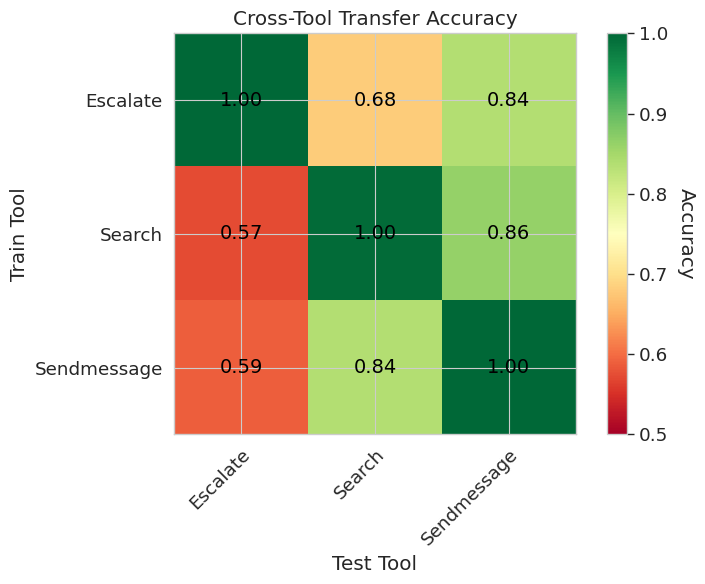

In [7]:
# Visualize transfer matrix
fig = plot_transfer_matrix(
    transfer_matrix,
    tool_labels=[t.capitalize() for t in tool_types],
    title="Cross-Tool Transfer Accuracy",
    save_path=config.figures_dir / "figure4_transfer_matrix",
)

plt.show()

In [8]:
# Compute average cross-tool transfer
# Exclude diagonal (within-tool)
mask = ~np.eye(len(tool_types), dtype=bool)
cross_tool_accuracies = transfer_matrix[mask]
mean_cross_tool = np.mean(cross_tool_accuracies)
std_cross_tool = np.std(cross_tool_accuracies)

mean_within_tool = np.mean(np.diag(transfer_matrix))

print(f"\n**Transfer Statistics:**")
print(f"  Mean within-tool accuracy: {mean_within_tool:.1%}")
print(f"  Mean cross-tool accuracy: {mean_cross_tool:.1%} ± {std_cross_tool:.3f}")
print(f"  Accuracy drop: {(mean_within_tool - mean_cross_tool):.1%}")

if mean_cross_tool > 0.85:
    print("\n  ✓ Cross-tool accuracy > 85%")
    print("  → Representation generalizes across tools!")
else:
    print(f"\n  ✗ Cross-tool accuracy = {mean_cross_tool:.1%} < 85%")
    print("  → Generalization may be limited")


**Transfer Statistics:**
  Mean within-tool accuracy: 99.9%
  Mean cross-tool accuracy: 73.0% ± 0.121
  Accuracy drop: 26.9%

  ✗ Cross-tool accuracy = 73.0% < 85%
  → Generalization may be limited


## 4. t-SNE Visualization

Visualize activation space colored by tool type.

In [9]:
# Sample for t-SNE (full dataset too large)
from sklearn.manifold import TSNE

# Sample 500 points (balanced across tools)
sampled_indices = []
for tool in tool_types:
    tool_indices = [i for i, s in enumerate(dataset_filtered.samples) if s.tool_type == tool]
    if len(tool_indices) > 166:
        np.random.seed(42)
        tool_indices = np.random.choice(tool_indices, 166, replace=False)
    sampled_indices.extend(tool_indices)

X_sample = dataset_filtered.activations[sampled_indices]
tool_labels = [dataset_filtered.samples[i].tool_type for i in sampled_indices]
action_labels = [dataset_filtered.samples[i].tool_used for i in sampled_indices]

print(f"Running t-SNE on {len(X_sample)} samples...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

print("t-SNE complete.")

Running t-SNE on 498 samples...
t-SNE complete.


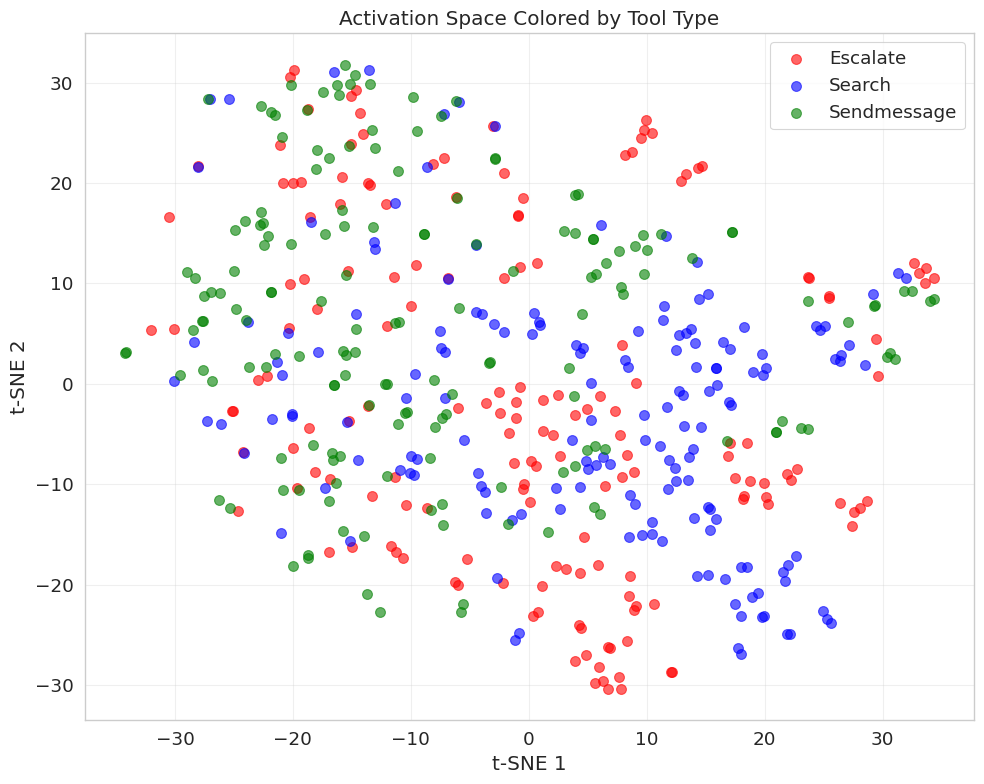

In [10]:
# Plot t-SNE colored by tool type
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'escalate': 'red', 'search': 'blue', 'sendMessage': 'green'}

for tool in tool_types:
    mask = np.array([t == tool for t in tool_labels])
    ax.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        c=colors[tool],
        label=tool.capitalize(),
        alpha=0.6,
        s=50,
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Activation Space Colored by Tool Type')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.figures_dir / "tsne_by_tool.png", dpi=300, bbox_inches='tight')
plt.show()

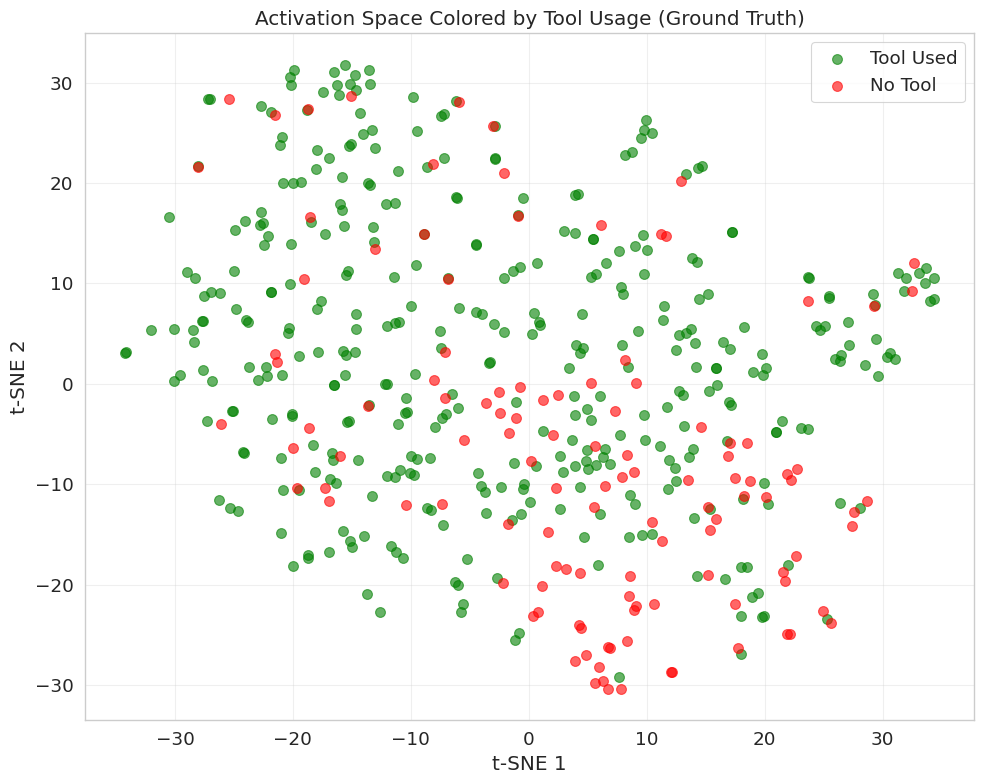

In [11]:
# Plot t-SNE colored by action (tool_used)
fig, ax = plt.subplots(figsize=(10, 8))

action_colors = {True: 'green', False: 'red'}
action_names = {True: 'Tool Used', False: 'No Tool'}

for action in [True, False]:
    mask = np.array([a == action for a in action_labels])
    ax.scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        c=action_colors[action],
        label=action_names[action],
        alpha=0.6,
        s=50,
    )

ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Activation Space Colored by Tool Usage (Ground Truth)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.figures_dir / "tsne_by_action.png", dpi=300, bbox_inches='tight')
plt.show()

## 5. Statistical Significance

Is cross-tool transfer significantly above chance?

In [12]:
# Permutation test on cross-tool transfer
from scipy.stats import ttest_1samp

# Test if cross-tool accuracies > 0.5 (chance)
t_stat, p_value = ttest_1samp(cross_tool_accuracies, 0.5)

print(f"\nOne-sample t-test (H0: accuracy = 0.5):")
print(f"  t = {t_stat:.3f}")
print(f"  p = {p_value:.4e}")
print(f"  Significant: {p_value < 0.05}")

# Effect size
from src.analysis.statistics import compute_effect_size
cohen_d = (mean_cross_tool - 0.5) / std_cross_tool
print(f"  Cohen's d: {cohen_d:.3f}")


One-sample t-test (H0: accuracy = 0.5):
  t = 4.260
  p = 8.0138e-03
  Significant: True
  Cohen's d: 1.905


## Summary

In [13]:
print("=" * 60)
print("PHASE 3 RESULTS: GENERALIZATION")
print("=" * 60)

print(f"\nWithin-Tool Accuracy:")
for tool, acc in within_tool_accuracies.items():
    print(f"  {tool}: {acc:.1%}")
print(f"  Mean: {mean_within_tool:.1%}")

print(f"\nCross-Tool Transfer:")
print(f"  Mean accuracy: {mean_cross_tool:.1%} ± {std_cross_tool:.3f}")
print(f"  Accuracy drop: {(mean_within_tool - mean_cross_tool):.1%}")

print(f"\nStatistical Significance:")
print(f"  p-value: {p_value:.4e}")
print(f"  Effect size (Cohen's d): {cohen_d:.3f}")

if mean_cross_tool > 0.85:
    print("\n✓ Cross-tool transfer > 85%")
    print("✓ Representation is general, not tool-specific")
else:
    print(f"\n⚠ Cross-tool transfer = {mean_cross_tool:.1%}")
    print("⚠ Generalization limited (but still above chance)")

print("=" * 60)

PHASE 3 RESULTS: GENERALIZATION

Within-Tool Accuracy:
  escalate: 84.2%
  search: 82.0%
  sendMessage: 91.1%
  Mean: 99.9%

Cross-Tool Transfer:
  Mean accuracy: 73.0% ± 0.121
  Accuracy drop: 26.9%

Statistical Significance:
  p-value: 8.0138e-03
  Effect size (Cohen's d): 1.905

⚠ Cross-tool transfer = 73.0%
⚠ Generalization limited (but still above chance)


## Next Steps

→ **Notebook 04:** Causal intervention via steering vectors